In [1]:
import pandas as pd
import numpy as np

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torchtext.vocab import GloVe

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
df = pd.read_pickle('initial_clean.pkl')

In [3]:
df.head()

,id_orig,name,license,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,id_re,date_re,results_re,time_between
16,577275,ROYALTY,1306130,Restaurant,2011-04-18,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,577343,2011-05-24,Pass,-36
38,1345428,PRET A MANGER,2138418,Restaurant,2013-08-06,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,1345448,2013-08-13,Pass,-7
43,1114379,PRET A MANGER,2138418,Restaurant,2012-07-23,Complaint,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,1114384,2012-07-31,Pass,-8
65,343293,CHIPOTLE MEXICAN GRILL,1379435,Restaurant,2010-08-17,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,343310,2010-08-26,Pass,-9
72,2484973,HILLTOP FAMILY RESTAURANT,2652370,Restaurant,2021-02-19,Canvass Re-Inspection,Fail,"44. UTENSILS, EQUIPMENT & LINENS: PROPERLY STO...",2485081,2021-02-23,Pass w/ Conditions,-4


In [4]:
# Change 'Pass w/ Conditions' to 'Pass', and change target to 0/1 numeric
results_dict = {'Pass': 0, 'Fail': 1}
df['results_re'] = df['results_re'].str.replace('Pass w/ Conditions', 'Pass')
df['results_re'] = df['results_re'].apply(lambda x: results_dict[x])

### Split data into feature & target, and then into train and test sets

In [5]:
# Sort dataframe by inspection date
# Training set will include initial 80% of inspections
sorted_df = df.sort_values(by=['date_orig'])

In [6]:
sorted_df.head()

,id_orig,name,license,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,id_re,date_re,results_re,time_between
217726,104236,TEMPO CAFE,80916,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,104243,2010-01-12,0,-8
494307,67738,MICHAEL'S ON MAIN CAFE,2008948,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,124279,2010-01-19,0,-15
452398,67736,"MONTICELLO FOOD MART, INC",2013259,Grocery Store,2010-01-05,License,Fail,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,54219,2010-01-08,0,-3
281119,67741,CITGO,2013296,Grocery Store,2010-01-05,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,176270,2010-02-17,0,-43
460847,67744,GOLDEN CROWN RESTAURANT,2013539,Restaurant,2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,48215,2010-01-11,1,-6


In [7]:
target_col = ['results_re']
target = sorted_df[target_col]

cols_to_exclude = ['name', 'id_orig', 'id_re', 'license']
feature_cols = [col for col in sorted_df.columns if (col not in cols_to_exclude and col not in target_col)]
features = sorted_df[feature_cols]

In [8]:
target.head()

,results_re
217726,0
494307,0
452398,0
281119,0
460847,1


In [9]:
features.head()

,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,date_re,time_between
217726,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-8
494307,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-19,-15
452398,Grocery Store,2010-01-05,License,Fail,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,2010-01-08,-3
281119,Grocery Store,2010-01-05,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,2010-02-17,-43
460847,Restaurant,2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2010-01-11,-6


In [10]:
# Don't shuffle data before splitting
train_feat, test_feat, train_targ, test_targ = train_test_split(features, target, test_size=0.2,
                                                                shuffle=False)

In [11]:
train_feat.head()

,facility_type,date_orig,inspection_type_orig,results_orig,violations_orig,date_re,time_between
217726,Restaurant,2010-01-04,Canvass,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-12,-8
494307,Restaurant,2010-01-04,License,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,2010-01-19,-15
452398,Grocery Store,2010-01-05,License,Fail,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,2010-01-08,-3
281119,Grocery Store,2010-01-05,License,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,2010-02-17,-43
460847,Restaurant,2010-01-05,License,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,2010-01-11,-6


In [12]:
pct_fail = len(train_targ[train_targ['results_re'] == 1]) / len(train_targ)
print(f'{pct_fail*100:.2f}% reinspections fail in training set')

8.80% reinspections fail in training set


### Split out the text features

In [13]:
text_col = ['violations_orig']
train_feat_txt = train_feat[text_col].astype(str)
test_feat_txt = test_feat[text_col].astype(str)

In [14]:
train_feat_txt.head()

,violations_orig
217726,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
494307,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...
452398,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...
281119,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...
460847,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...


### Split the text into tokens

In [15]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()

In [16]:
# Create vocab using training set only!!!!
for idx, text in train_feat_txt.itertuples():
    counter.update(tokenizer(text))

In [17]:
# Not sure what the min frequency should be
# Min freq = 1 -> 50768 vocab length
# Min freq = 50 -> 2942
# Min freq = 100 -> 2211
# Min freq = 250 -> 1481
# Min freq = 500 -> 1107
# Min freq = 1000 -> 806
MIN_FREQ = 500
vocab = Vocab(counter, min_freq=MIN_FREQ)

In [18]:
len(vocab)

1086

### Create BOW features

In [19]:
def collate_into_bow(data, voc=vocab):
    bow = torch.zeros((len(data), len(voc) + 1))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        counter = Counter()
        counter.update(tokenizer(text))
        line_vocab = Vocab(counter)
        tot_freqs = sum(line_vocab.freqs.values())
        labels[i] = label
        for token in line_vocab.freqs:
            bow[i, voc.stoi[token]] = line_vocab.freqs[token] / tot_freqs  # Using relative frequencies
            bow[i, -1] = tot_freqs
    
    return (labels, bow)

### __Create CBOW features__

In [20]:
VECTORS_CACHE_DIR = './.vector_cache'
DIM_GLOVE = 300

glove = GloVe('6B',cache=VECTORS_CACHE_DIR)

In [21]:
def collate_into_cbow(data):
    cbow = torch.zeros((len(data), DIM_GLOVE))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        counter = Counter()
        counter.update(tokenizer(text))
        tokens = list(Vocab(counter).freqs)
        vecs = glove.get_vecs_by_tokens(tokens)
        cbow[i] = torch.mean(vecs, axis=0)
        labels[i] = label
    return (labels, cbow)


### Create ngram features

In [22]:
# Using CountVectorizer to get ngrams (this was the most intuitive tool I could find...)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
def divide_rows_by_row_sum(arr):
    return np.nan_to_num(
            np.divide(arr, arr.sum(axis=1)[:, None]),
            nan=0  # Small number of ngram rows are all zeroes; don't divide row by 0 
    )

In [24]:
vectorizer = CountVectorizer(min_df=MIN_FREQ, ngram_range=(2,2))
corpus = train_feat_txt['violations_orig'].to_list()
vocab_ngrams = vectorizer.fit_transform(corpus)

In [25]:
#I'm not sure how to get this to include document length, since
#I had to alter the BOW collate function so it would work
#with the dataloader

def collate_into_ngrams(data, voc=vocab_ngrams):
    ngrams = torch.zeros((len(data), voc.shape[1]))
    labels = torch.zeros((len(data), 1))
    for i, (label, text) in enumerate(data):
        X_batch = vectorizer.transform([text])
        ngram_arr = X_batch.toarray()
        ngram_arr = divide_rows_by_row_sum(ngram_arr)
        ngrams[i, :] = torch.tensor(ngram_arr)
        labels[i] = label
    
    return (labels, ngrams)

### Split train set into train and validation

In [26]:
train_x, val_x, train_y, val_y = train_test_split(train_feat_txt, train_targ,
                                                    test_size=0.2, shuffle=False)

In [27]:
#Oversample on target vector
train_targ_reset = train_y.reset_index().drop('index', axis=1)
train_targ_fail = train_targ_reset[train_targ_reset['results_re'] == 1]
size_diff = train_targ_reset.shape[0] - train_targ_fail.shape[0]
train_resample = resample(train_targ_fail, n_samples = size_diff, replace=True)
train_targ_all = pd.concat([train_targ_reset, train_resample])

In [28]:
from torch.utils.data import Dataset, DataLoader

class InspectionsDataset(Dataset):
    def __init__(self, features_df, target_df):

        self.features_text = features_df['violations_orig']
        self.labels = target_df['results_re']

    def __len__(self):
        return len(self.features_text)

    def __getitem__(self, idx):
        text = self.features_text.iloc[idx]
        label = self.labels.iloc[idx]

        return (label, text)

In [29]:
#then resample features
train_x_reset = train_x.reset_index().drop('index', axis=1)
train_x_resample = train_x_reset.iloc[train_targ_all.index]

#and convert to dataset object
inspections_train = InspectionsDataset(train_x_resample, train_targ_all)
inspections_val = InspectionsDataset(val_x, val_y)
inspections_test = InspectionsDataset(test_feat_txt, test_targ)

#these can all now be fed into DataLoaders with the proper collate functions

### Bag of Words

In [30]:
BATCH_SIZE=64

In [64]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_bow)
valid_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_bow)


In [65]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):

    def __init__(self, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 32)
        self.linear2 = nn.Linear(32, 1)
        self.hidden1 = nn.ReLU()
        self.hidden2 = nn.Sigmoid()
    
    def forward(self, bow_vec):
        x = self.hidden1(self.linear1(bow_vec))
        x = self.hidden2(self.linear2(x))
        return x
        #return F.log_softmax(self.linear(bow_vec), dim=1)


In [42]:
loss_function = torch.nn.BCELoss()

def train_an_epoch(dataloader):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

In [47]:
def get_accuracy(dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            outputs = model(text)
            predicted = torch.round(outputs)
            #predicted = torch.max(outputs.data, 1)[1]
            total += label.size(0)
            correct += (predicted == label).sum().item()
    
    print("Total: {}, correct: {}".format(total, correct))
    return(correct/total)

At iteration 500 the loss is 48.450.
Total: 5953, correct: 551

After epoch 1 the validation accuracy is 0.093.

At iteration 500 the loss is 31.273.
Total: 5953, correct: 551

After epoch 2 the validation accuracy is 0.093.

At iteration 500 the loss is 48.467.
Total: 5953, correct: 551

After epoch 3 the validation accuracy is 0.093.



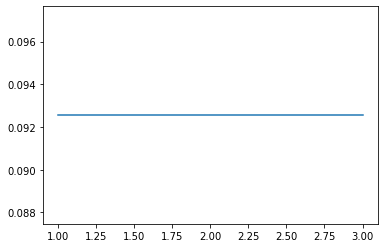

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

num_labels = 2
vocab_size = len(vocab) + 1
model = BoWClassifier(vocab_size)
EPOCHS = 3 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

#reset/clear out model just in case
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

### Continuous Bag of Words

In [142]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_cbow)
val_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_cbow)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_cbow)

### Ngrams

In [143]:
#create dataloaders
train_dataloader = DataLoader(inspections_train, batch_size=BATCH_SIZE, shuffle=True, 
                                collate_fn=collate_into_ngrams)
val_dataloader = DataLoader(inspections_val, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_ngrams)
test_dataloader = DataLoader(inspections_test, batch_size=BATCH_SIZE, shuffle=False, 
                                collate_fn=collate_into_ngrams)